In [1]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape

In [2]:
stack_idx = '18'
models = '1-10,12-22,24-29'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = False
add_intercept = True

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29]


In [5]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [6]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [7]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [8]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [9]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
27
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.0005-350-cv.csv
model-27-lgb-feat_rm_new-cv.csv
m

In [10]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 11 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 12 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 13 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 14 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 15 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 16 file: model-18-lgb-feats-selection-70-lr-0.001-p5-test

In [11]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_27,log_parea_pred_27,pred_28,log_pred_28,log_parea_pred_28,pred_29,log_pred_29,log_parea_pred_29,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.381324,12.152221,6.374413e+05,13.365219,12.136116,6.274171e+05,13.349368,12.120265,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.955716,13.559149,3.160098e+06,14.966114,13.569546,3.145481e+06,14.961478,13.564910,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.092359,14.372404,9.804749e+06,16.098377,14.378423,9.762486e+06,16.094058,14.374103,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.348848,13.741502,1.263065e+07,16.351637,13.744290,1.262574e+07,16.351248,13.743901,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.938992,12.393966,1.132637e+06,13.940060,12.395034,1.128514e+06,13.936413,12.391388,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27,pred_28,log_pred_28,log_parea_pred_28,pred_29,log_pred_29,log_parea_pred_29
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.195091,1.405424e+07,16.458435,15.229328,1.485198e+07,16.513644,15.284537,1.458851e+07,16.495745,15.266638
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.135851,3.932854e+06,15.184876,13.140257,3.925095e+06,15.182901,13.138282,3.930381e+06,15.184247,13.139628
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.692710,1.040041e+07,16.157355,13.658335,1.066340e+07,16.182328,13.683307,1.053625e+07,16.170332,13.671312
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.801146,5.905111e+06,15.591329,14.779397,6.025775e+06,15.611557,14.799625,5.922934e+06,15.594343,14.782410
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.147091,1.048505e+06,13.862877,12.102615,1.078927e+06,13.891479,12.131217,1.092658e+06,13.904125,12.143863


### Check models scores

In [12]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-12 5486.856963
11 model-13 5506.858055
12 model-14 5908.873901
13 model-15 5900.873836
14 model-16 5907.874126
15 model-17 5905.874165
16 model-18 5908.874297
17 model-19 5911.874156
18 model-20 5908.874040
19 model-21 5758.870702
20 model-22 5752.870671
21 model-24 5866.873835
22 model-25 5908.874238
23 model-26 5918.873998
24 model-27 5892.873194
25 model-28 5901.874202
26 model-29 5884.873848


In [13]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [14]:
def objective(x, cv, metric, best_score, best_coeffs, verbose):
    cv_pred_final = cv[cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        if verbose:
            print('find better score:')
            print('score: ', score)
            print('coeffs: ', x)
            print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### CV

In [16]:
from sklearn.model_selection import KFold

cv = cv.reset_index(drop=True)
#cv = cv.head(100)

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [[1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       (np.random.randn(len_x)+1)/len_x,
       (np.random.randn(len_x)+1)/len_x,
       (np.random.randn(len_x)+1)/len_x,
      ]
#bounds = tuple([(0, 1) for i in range(len_x-1)] + [(-2, 2)])

score_list = []

kf = KFold(shuffle= True)
for idx_train, idx_val in kf.split(cv):

    best_score = {}
    best_coeffs = {}
    
    cv_fold_train = cv.loc[idx_train].reset_index(drop=True)
    cv_fold_val = cv.loc[idx_train].reset_index(drop=True)
    
    for metric in ['mape']:
    #for metric in ['mape', 'mae', 'mse']:
        best_score[metric] = 0
        best_coeffs[metric] = []
        for x0 in x0s:
            print('Optimizing with init x0: {}'.format(x0))
            print()
            minimize(objective, x0, args=(cv_fold_train, metric, best_score, best_coeffs, 
                                          True), 
                     tol=1e-6) #, bounds=bounds
    
    val_pred_final = cv_fold_val[cols_opt].dot(best_coeffs['mape'])
    if is_per_area:
        val_pred_final = np.expm1(val_pred_final) * cv_fold_val['building_area']
    else:
        val_pred_final = np.expm1(val_pred_final)
    score = cal_score(cv_fold_val['total_price'], val_pred_final)
    
    score_list.append(score)

print('CV score ?: {}; {}'.format(np.mean(score_list), score_list))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]

find better score:
score:  159.59858851042463
coeffs:  [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]

find better sco

find better score:
score:  5906.875214464402
coeffs:  [0.03684372 0.03680387 0.03687927 0.03688722 0.03697354 0.03685758
 0.03689361 0.03696921 0.03686838 0.03690102 0.03680732 0.03681819
 0.03690699 0.03688899 0.03691865 0.03691431 0.03694069 0.03693321
 0.03692365 0.03693492 0.03694711 0.03711368 0.03695518 0.0369157
 0.03698817 0.0369364  0.03694941 0.03468777]

find better score:
score:  5944.87543106301
coeffs:  [0.03642122 0.0362317  0.03673466 0.03666863 0.03769486 0.03651949
 0.03584754 0.0375787  0.03655438 0.03679429 0.03618287 0.03608401
 0.03685206 0.03672246 0.03696194 0.03696736 0.0371858  0.03707822
 0.03694545 0.03752251 0.03761593 0.03869205 0.03723821 0.03696813
 0.03732822 0.03708759 0.037162   0.02839912]

find better score:
score:  5944.875564099377
coeffs:  [0.03496349 0.03405977 0.036047   0.03613186 0.0399547  0.03530822
 0.03186586 0.03968301 0.03550457 0.03628296 0.03419317 0.03401016
 0.03652807 0.03601052 0.03702159 0.03703005 0.03797723 0.03741353
 0.036871

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [ 0.05680843  0.05460251  0.07543773  0.08991609  0.12250331  0.04899841
 -0.00961433  0.05496768  0.06354434 -0.01069053  0.05769499 -0.01309905
  0.02019328  0.08370317  0.01419412  0.00074808  0.04371687  0.04025455
  0.04984775 -0.02777625 -0.00354357  0.00661309  0.08188885 -0.03291213
  0.06752455  0.04359755 -0.00437304  0.0050986 ]

Optimizing with init x0: [ 0.0279337   0.04997354  0.03231929  0.0451501   0.06997417  0.07136585
  0.06102455  0.02387806 -0.04230673 -0.02575887  0.02290282  0.03962276
  0.08056474  0.00197095  0.03997691 -0.00154781  0.03926418  0.07067112
  0.02494679  0.0648618   0.02889844 -0.02562946  0.01094172 -0.01740679
  0.00808408  0.04355358  0.03349836  0.03492641]

find better score:
score:  5952.875968613513
coeffs:  [ 0.00425329  0.02693913  0.02594785  0.0502754   0.07107893  0.05276211
  0.0224108   0.0855202  -0.04962105 -0.02613135  0.0293115   0.03004497
  0.08336917 -0.00173179  0.04843656  0.0075559   0.06082092  0.

find better score:
score:  5928.876219930964
coeffs:  [0.0368174  0.03698025 0.03687244 0.0367909  0.03698673 0.03684468
 0.03715724 0.03701766 0.03680719 0.03685984 0.0369344  0.03699454
 0.03686907 0.03685882 0.03688137 0.03688771 0.03690466 0.03689623
 0.03689019 0.03695976 0.03696622 0.03706283 0.03692291 0.03687679
 0.03694791 0.03690852 0.0369112  0.03465234]

find better score:
score:  5928.876219941979
coeffs:  [0.03681741 0.03698025 0.03687244 0.0367909  0.03698673 0.03684468
 0.03715724 0.03701766 0.03680719 0.03685984 0.0369344  0.03699454
 0.03686907 0.03685882 0.03688137 0.03688771 0.03690466 0.03689623
 0.03689019 0.03695976 0.03696622 0.03706283 0.03692291 0.03687679
 0.03694791 0.03690852 0.0369112  0.03465234]

find better score:
score:  5928.876219941996
coeffs:  [0.0368174  0.03698026 0.03687244 0.0367909  0.03698673 0.03684468
 0.03715724 0.03701766 0.03680719 0.03685984 0.0369344  0.03699454
 0.03686907 0.03685882 0.03688137 0.03688771 0.03690466 0.03689623
 0.0368

find better score:
score:  5962.877043811786
coeffs:  [-0.08314681  0.04536766  0.04711028  0.01541744  0.04883067 -0.0134374
  0.03198991  0.05905538 -0.09581391 -0.02157234  0.0208244   0.04067028
  0.0128369  -0.01066379  0.02671108  0.05461756  0.06555364  0.04316938
 -0.00828266  0.06246409  0.06832455  0.22702396  0.08061108  0.00933439
  0.17594967  0.06075918  0.04175432 -0.09547527]

find better score:
score:  5962.877149448978
coeffs:  [-0.14372839  0.04001846  0.09582    -0.0044849   0.04966642  0.09324812
  0.04290543  0.06468456 -0.15665637 -0.256534    0.01059742  0.04434936
  0.22135832 -0.12118508 -0.04231752  0.39020146  0.06768814  0.05956602
 -0.48800997  0.05862878  0.07623979  0.19946535  0.47071284 -0.26991804
  0.31418758  0.28400544 -0.09547437 -0.08890842]

find better score:
score:  5962.877149449026
coeffs:  [-0.14372838  0.04001846  0.09582    -0.0044849   0.04966642  0.09324812
  0.04290543  0.06468456 -0.15665637 -0.256534    0.01059742  0.04434936
  0.221

find better score:
score:  5962.877149892038
coeffs:  [-0.14207274  0.04065924  0.09399864 -0.00472657  0.05160299  0.08930955
  0.04360835  0.06185426 -0.15644018 -0.25649079  0.01018495  0.04531726
  0.22086814 -0.12127636 -0.04630713  0.38751136  0.06213469  0.06339866
 -0.48409429  0.0579338   0.07520885  0.20158895  0.47044415 -0.26310993
  0.31068542  0.28373918 -0.09049269 -0.08889669]

find better score:
score:  5962.877150854251
coeffs:  [-0.13910217  0.04271098  0.10204093 -0.00548181  0.05267706  0.07922961
  0.04533851  0.05951197 -0.16290365 -0.25807341  0.01109398  0.04377285
  0.23482174 -0.11797075 -0.05636092  0.39744847  0.04775459  0.07143225
 -0.49577852  0.05836416  0.07395557  0.20360939  0.47398817 -0.25259423
  0.30602548  0.28193925 -0.09230915 -0.09051294]

find better score:
score:  5962.877152094356
coeffs:  [-0.13555889  0.0400095   0.12479774 -0.00504706  0.05193454  0.05889741
  0.04506715  0.06227706 -0.17868074 -0.25256858  0.01276885  0.04385421
  0.25

find better score:
score:  5965.87715460533
coeffs:  [-0.14766599  0.04059417  0.11808373 -0.00248988  0.06613455  0.07594468
  0.04466775  0.06381579 -0.16734117 -0.30994594  0.01091212  0.04349504
  0.30104291 -0.11126916 -0.09941323  0.47265363 -0.0022583   0.12621137
 -0.58715656  0.04367053  0.07276737  0.209521    0.44641985 -0.1854783
  0.29055389  0.27854569 -0.08693983 -0.08954065]

find better score:
score:  5965.8771546104745
coeffs:  [-0.1482797   0.04049594  0.11872301 -0.00242833  0.0661143   0.07514472
  0.04474981  0.06397334 -0.16743772 -0.30924375  0.01082964  0.04357003
  0.30182266 -0.1107866  -0.09971153  0.47251035 -0.00298713  0.12640934
 -0.58735448  0.04381261  0.07257179  0.20944254  0.44626707 -0.18510706
  0.2902402   0.27829743 -0.08656231 -0.08955   ]

find better score:
score:  5965.8771546135795
coeffs:  [-0.14822573  0.04050713  0.11847756 -0.00252951  0.06603407  0.075134
  0.04469105  0.06401742 -0.16714491 -0.30951564  0.01087887  0.04350375
  0.3020

find better score:
score:  5965.8771546217395
coeffs:  [-0.14758821  0.04051048  0.11745053 -0.00240469  0.06575438  0.0743712
  0.04459711  0.06420039 -0.16647025 -0.31059947  0.01070092  0.04351507
  0.30373662 -0.11159759 -0.09972404  0.47374179 -0.00397065  0.12786467
 -0.58918652  0.04330833  0.0734057   0.20963098  0.44545745 -0.18515606
  0.29006657  0.27993454 -0.08647313 -0.08955851]

find better score:
score:  5965.8771546218795
coeffs:  [-0.14753289  0.04050873  0.1174159  -0.00240496  0.06574585  0.07433069
  0.04459112  0.06420946 -0.16646264 -0.31061637  0.01070031  0.04350568
  0.30372049 -0.11162273 -0.09970516  0.47372427 -0.00392851  0.12788637
 -0.58915735  0.04329475  0.07343357  0.20963635  0.44541375 -0.18516569
  0.29006341  0.2799846  -0.08649292 -0.08955815]

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [ 0.05680843  0.05460251  0.07543773  0.08991609  0.12250331  0.04899841
 -0.00961433  0.05496768  0.06354434 -0.01069053  0.05769499 -0.01309905
  0.02019328  0.08370317  0.01419412  0.00074808  0.04371687  0.04025455
  0.04984775 -0.02777625 -0.00354357  0.00661309  0.08188885 -0.03291213
  0.06752455  0.04359755 -0.00437304  0.0050986 ]

Optimizing with init x0: [ 0.0279337   0.04997354  0.03231929  0.0451501   0.06997417  0.07136585
  0.06102455  0.02387806 -0.04230673 -0.02575887  0.02290282  0.03962276
  0.08056474  0.00197095  0.03997691 -0.00154781  0.03926418  0.07067112
  0.02494679  0.0648618   0.02889844 -0.02562946  0.01094172 -0.01740679
  0.00808408  0.04355358  0.03349836  0.03492641]

Optimizing with init x0: [ 0.05964884  0.02213104  0.0714178   0.01496412  0.08967602  0.04600564
  0.04662007  0.02286208  0.02100565  0.05395717  0.12157557  0.03874766
  0.02627255  0.01172522 -0.01467094  0.00145715  0.09116593 -0.00502322
  0.10327616  0.0323

find better score:
score:  5903.875405434312
coeffs:  [0.03684767 0.03679025 0.0369285  0.03683447 0.03703928 0.0368875
 0.03690948 0.03695436 0.03688407 0.03688705 0.03680585 0.03676313
 0.03689356 0.03688236 0.03690425 0.03690756 0.03693027 0.03690453
 0.03689739 0.03702374 0.0370299  0.03711797 0.03693258 0.03688068
 0.03697793 0.03691412 0.03694953 0.03466027]

find better score:
score:  5931.875628358681
coeffs:  [0.03640685 0.03583899 0.03706867 0.03635659 0.03819044 0.03676095
 0.03597365 0.03720713 0.03665239 0.03669633 0.03634262 0.03583348
 0.03675831 0.03666942 0.03686415 0.03692288 0.03708439 0.0369146
 0.03683192 0.03815561 0.03817094 0.03877424 0.03710118 0.03671736
 0.03720558 0.03697962 0.03718168 0.02796545]

find better score:
score:  5933.875680511877
coeffs:  [0.03598287 0.03502952 0.03716546 0.03600693 0.03924786 0.03660894
 0.03498739 0.0375235  0.03641    0.03644821 0.0358827  0.03511352
 0.03656161 0.0364131  0.03677596 0.03687506 0.03719126 0.03687078
 0.036707

find better score:
score:  5954.876518637875
coeffs:  [-0.19312455  0.00645067  0.2146294   0.01709775  0.07352665  0.03119798
  0.01990338  0.11005865 -0.06911421 -0.03778502  0.01867982 -0.00301241
  0.02393657 -0.03597654  0.04334234  0.09298706  0.14829718 -0.04102365
 -0.14267691  0.06973138  0.0719516   0.31610856  0.05733832 -0.1263389
  0.23154333 -0.01550394  0.12339373 -0.09939025]

find better score:
score:  5954.876518637884
coeffs:  [-0.19312453  0.00645067  0.2146294   0.01709775  0.07352665  0.03119798
  0.01990338  0.11005865 -0.06911421 -0.03778502  0.01867982 -0.00301241
  0.02393657 -0.03597654  0.04334234  0.09298706  0.14829718 -0.04102365
 -0.14267691  0.06973138  0.0719516   0.31610856  0.05733832 -0.1263389
  0.23154333 -0.01550394  0.12339373 -0.09939025]

find better score:
score:  5954.876518637886
coeffs:  [-0.19312455  0.00645068  0.2146294   0.01709775  0.07352665  0.03119798
  0.01990338  0.11005865 -0.06911421 -0.03778502  0.01867982 -0.00301241
  0.0239

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [ 0.05680843  0.05460251  0.07543773  0.08991609  0.12250331  0.04899841
 -0.00961433  0.05496768  0.06354434 -0.01069053  0.05769499 -0.01309905
  0.02019328  0.08370317  0.01419412  0.00074808  0.04371687  0.04025455
  0.04984775 -0.02777625 -0.00354357  0.00661309  0.08188885 -0.03291213
  0.06752455  0.04359755 -0.00437304  0.0050986 ]

find better score:
score:  5956.876524125141
coeffs:  [-0.20464262  0.00396365  0.2118781   0.02742411  0.0668729   0.03330394
  0.02190345  0.11160048 -0.08162301 -0.07297689  0.0114972   0.0071817
  0.01960707  0.00449934  0.04075705  0.08768844  0.17867912 -0.02540648
 -0.13778517  0.06135853  0.08631391  0.30232036  0.10649216 -0.17729767
  0.22238381 -0.00960564  0.10939377 -0.10212331]

find better score:
score:  5956.876524125304
coeffs:  [-0.20464261  0.00396365  0.2118781   0.02742411  0.0668729   0.03330394
  0.02190345  0.11160048 -0.08162301 -0.07297689  0.0114972   0.0071817
  0.01960707  0.00449934  0.04075705 

### Optimize

In [17]:
best_score = {}
best_coeffs = {}

for metric in ['mape']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(cv, metric, best_score, best_coeffs, True), tol=1e-6)

Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]

find better score:
score:  156.5981583838929
coeffs:  [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]

find better scor

find better score:
score:  5911.875611757613
coeffs:  [0.0368362  0.03686451 0.0368926  0.0368372  0.03700047 0.03686263
 0.03698463 0.03698267 0.03685211 0.03688202 0.03685359 0.03685976
 0.0368892  0.03687611 0.03690067 0.0369028  0.03692479 0.03691064
 0.03690267 0.03697353 0.03698177 0.03709793 0.03693596 0.03689029
 0.0369695  0.03691901 0.03693528 0.03466901]

find better score:
score:  5943.875817822558
coeffs:  [0.03632955 0.03661403 0.03681108 0.03624201 0.03775752 0.03656879
 0.03657494 0.03754871 0.03643649 0.03666271 0.03659777 0.03645497
 0.03673492 0.03663481 0.03683866 0.03689134 0.03704486 0.0369453
 0.036836   0.03769251 0.03773829 0.03853019 0.03712697 0.03678771
 0.03719697 0.03700261 0.03706455 0.0282387 ]

find better score:
score:  5943.875863979485
coeffs:  [0.03586087 0.03632705 0.03668608 0.03583114 0.03844582 0.03626685
 0.03608224 0.03808078 0.03604485 0.03641599 0.03631241 0.03614089
 0.03654487 0.03637243 0.03674569 0.03683539 0.03713206 0.03694301
 0.03673

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [ 0.05680843  0.05460251  0.07543773  0.08991609  0.12250331  0.04899841
 -0.00961433  0.05496768  0.06354434 -0.01069053  0.05769499 -0.01309905
  0.02019328  0.08370317  0.01419412  0.00074808  0.04371687  0.04025455
  0.04984775 -0.02777625 -0.00354357  0.00661309  0.08188885 -0.03291213
  0.06752455  0.04359755 -0.00437304  0.0050986 ]

find better score:
score:  5956.876569970224
coeffs:  [-0.14924537  0.02065284  0.15447252  0.02986997  0.05711216 -0.0269965
  0.02428037  0.08938807 -0.10048924 -0.07710143  0.00635956  0.02824662
  0.04190531 -0.01594752  0.05611053  0.10744571  0.21420746  0.00226754
 -0.16186043  0.03667988  0.09134824  0.25782748  0.14505102 -0.14034291
  0.24767992  0.02822688  0.03860352 -0.10088533]

Optimizing with init x0: [ 0.0279337   0.04997354  0.03231929  0.0451501   0.06997417  0.07136585
  0.06102455  0.02387806 -0.04230673 -0.02575887  0.02290282  0.03962276
  0.08056474  0.00197095  0.03997691 -0.00154781  0.03926418  0.0

In [18]:
display(best_score)
display(best_coeffs)

{'mape': 5956.876569970224}

{'mape': array([-0.14924537,  0.02065284,  0.15447252,  0.02986997,  0.05711216,
        -0.0269965 ,  0.02428037,  0.08938807, -0.10048924, -0.07710143,
         0.00635956,  0.02824662,  0.04190531, -0.01594752,  0.05611053,
         0.10744571,  0.21420746,  0.00226754, -0.16186043,  0.03667988,
         0.09134824,  0.25782748,  0.14505102, -0.14034291,  0.24767992,
         0.02822688,  0.03860352, -0.10088533])}

### Compute submission

In [19]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['mape'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}.csv'.format(stack_idx, models), index=False)

### Plots

In [20]:
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


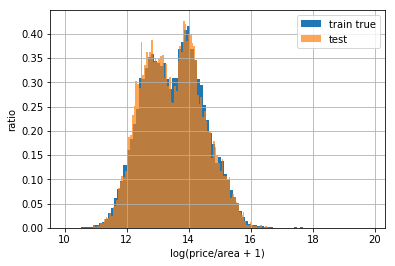

In [21]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


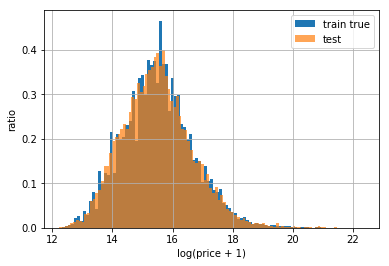

In [22]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


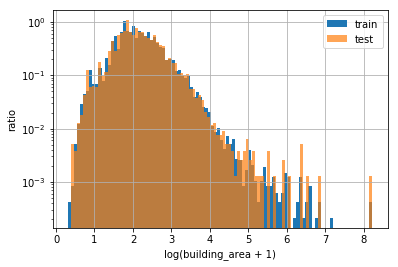

In [23]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()